In [1]:
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 4. Fitting a distribution

In [2]:
df = pd.read_csv('data/sample_claims.csv')

In [5]:
loc, scale = st.distributions.norm.fit(df)

In [4]:
x = np.linspace(df.min(),df.max(),df.shape[0])

In [6]:
# st.norm.stats(moments='mvsk')

(array(0.), array(1.), array(0.), array(0.))

In [25]:
fitted_data = st.distributions.norm.pdf(x, loc, scale)

(array([1.53133903e-04, 1.06837607e-05, 1.78062678e-06, 1.78062678e-06,
        1.78062678e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.78062678e-06]),
 array([2.4000e+01, 5.8740e+03, 1.1724e+04, 1.7574e+04, 2.3424e+04,
        2.9274e+04, 3.5124e+04, 4.0974e+04, 4.6824e+04, 5.2674e+04,
        5.8524e+04]),
 <BarContainer object of 10 artists>)

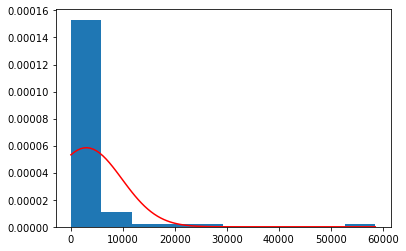

In [26]:
plt.plot(x,fitted_data,'r-')
plt.hist(df, density=True)

### Evaluating the goodness of fit

In [28]:
log_likelihood = np.sum(np.log(st.norm.pdf(df, loc, scale)))

In [31]:
-2*log_likelihood + 2*2

1971.346878750647

In [32]:
from fitter import Fitter, get_common_distributions, get_distributions

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,3.660319e-07,4051.531062,-1851.821094,inf,0.331834,6.362302e-10


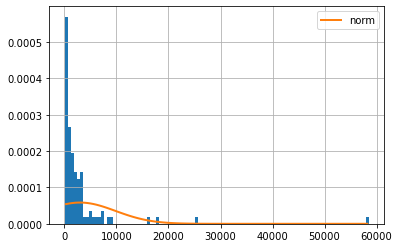

In [39]:
f = Fitter(df, distributions=["norm"])
f.fit()
f.summary()